### Multi-Label Classification

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import numpy as np

from copy import deepcopy 

In [2]:
train_rawdata = datasets.MNIST(root = 'dataset',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root = 'dataset',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())
print('number of training data : ', len(train_rawdata))
print('number of test data : ', len(test_dataset))

number of training data :  60000
number of test data :  10000


### Validation dataset 

In [3]:
VALIDATION_RATE = 0.2
train_indices, val_indices, _, _ = train_test_split(
    range(len(train_rawdata)), # X index 
    train_rawdata.targets, # y
    stratify=train_rawdata.targets, # 
    test_size=VALIDATION_RATE
)

### Create Validation dataset 

In [4]:
train_dataset = Subset(train_rawdata, train_indices)
validation_dataset = Subset(train_rawdata, val_indices)

### dataset size

In [5]:
print (len(train_dataset), len(validation_dataset), len(test_dataset))

48000 12000 10000


### Create Mini-batch 

In [6]:
minibatch_size = 128
# create batches
train_batches = DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True)
val_batches = DataLoader(validation_dataset, batch_size=minibatch_size, shuffle=True)
test_batches = DataLoader(test_dataset, batch_size=minibatch_size, shuffle=False)

### Model

In [7]:
class Layer(nn.Module):
    def __init__(self, input_size, output_size, batch_norm=True, dropout=0.5):
        self.input_size = input_size
        self.output_size = output_size
        self.batch_norm = batch_norm
        self.dropout = dropout
        
        super().__init__()
        
        self.layer = nn.Sequential (
            nn.Linear(input_size, output_size),
            nn.LeakyReLU(), # LeakyReLU 기본값은 0.01
            self.apply_regularization()
        )
        
    def apply_regularization(self):
        if self.batch_norm:
            return nn.BatchNorm1d(self.output_size)
        else:
            return nn.Dropout(self.dropout)
    
    def forward(self, x):
        return self.layer(x)

### Model Class

In [8]:
class DNNModel(nn.Module):
    def __init__(self, input_size, output_size, batch_norm=True, dropout=0.5):
        super().__init__()
        
        self.layers = nn.Sequential (
            Layer(input_size, 256, batch_norm, dropout),
            Layer(256, 256, batch_norm, dropout),
            Layer(256, 128, batch_norm, dropout),
            nn.Linear(128, output_size),
            nn.LogSoftmax(dim=-1)
        )
        
    def forward(self, x):
        return self.layers(x)

### input, output, model 

In [9]:
input_dim = 28 * 28 # 784
output_dim = 10
model = DNNModel(input_dim, output_dim)
# model = DNNModel(input_dim, output_dim, False, 0.2)
model

DNNModel(
  (layers): Sequential(
    (0): Layer(
      (layer): Sequential(
        (0): Linear(in_features=784, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Layer(
      (layer): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Layer(
      (layer): Sequential(
        (0): Linear(in_features=256, out_features=128, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Linear(in_features=128, out_features=10, bias=True)
    (4): LogSoftmax(dim=-1)
  )
)

### loss function, optimizer 설정

In [10]:
loss_func = nn.NLLLoss() 
optimizer = torch.optim.Adam(model.parameters()) 

### Training Code

In [11]:
def train_model(model, early_stop, n_epochs, progress_interval):
    
    train_losses, valid_losses, lowest_loss = list(), list(), np.inf

    for epoch in range(n_epochs):
        
        train_loss, valid_loss = 0, 0
        
        # train the model
        model.train() # prep model for training
        for x_minibatch, y_minibatch in train_batches:
            y_minibatch_pred = model(x_minibatch.view(x_minibatch.size(0), -1))
            loss = loss_func(y_minibatch_pred, y_minibatch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss = train_loss / len(train_batches)
        train_losses.append(train_loss)      
        
        # validate the model
        model.eval()
        with torch.no_grad():
            for x_minibatch, y_minibatch in val_batches:
                y_minibatch_pred = model(x_minibatch.view(x_minibatch.size(0), -1))
                loss = loss_func(y_minibatch_pred, y_minibatch)
                valid_loss += loss.item()
                
        valid_loss = valid_loss / len(val_batches)
        valid_losses.append(valid_loss)

        if valid_losses[-1] < lowest_loss:
            lowest_loss = valid_losses[-1]
            lowest_epoch = epoch
            best_model = deepcopy(model.state_dict())
        else:
            if (early_stop > 0) and lowest_epoch + early_stop < epoch:
                print ("Early Stopped", epoch, "epochs")
                break
                
        if (epoch % progress_interval) == 0:
            print (train_losses[-1], valid_losses[-1], lowest_loss, lowest_epoch, epoch)
            
    model.load_state_dict(best_model)        
    return model, lowest_loss, train_losses, valid_losses

### Training

In [12]:
nb_epochs = 30 
progress_interval = 3
early_stop = 10

model, lowest_loss, train_losses, valid_losses = train_model(model, early_stop, nb_epochs, progress_interval)

0.21148274648189544 0.11404908920063618 0.11404908920063618 0 0
0.04591652218376597 0.0886069684824411 0.08623215761233835 2 3
0.026136781143645444 0.08609386512692621 0.08224763087135681 4 6
0.01717636330689614 0.08808620188613125 0.08214578463477974 8 9
0.017186192125237237 0.09054750527324591 0.08214578463477974 8 12
0.015471285574370995 0.08965001367230682 0.08214578463477974 8 15
0.011232440910302103 0.0879399034623775 0.08214578463477974 8 18
Early Stopped 19 epochs


### Test set Evaluation 

In [13]:
test_loss = 0
correct = 0
wrong_samples, wrong_preds, actual_preds = list(), list(), list()

model.eval()
with torch.no_grad():
    for x_minibatch, y_minibatch in test_batches:
        y_test_pred = model(x_minibatch.view(x_minibatch.size(0), -1))
        test_loss += loss_func(y_test_pred, y_minibatch)  
        pred = torch.argmax(y_test_pred, dim=1)
        correct += pred.eq(y_minibatch).sum().item()
        
        wrong_idx = pred.ne(y_minibatch).nonzero()[:, 0].numpy().tolist()
        for index in wrong_idx:
            wrong_samples.append(x_minibatch[index])
            wrong_preds.append(pred[index])
            actual_preds.append(y_minibatch[index])
            
test_loss /= len(test_batches.dataset)
print('Average Test Loss: {:.4f}'.format( test_loss ))
print('Accuracy: {}/{} ({:.2f}%)'.format( correct, len(test_batches.dataset), 100 * correct / len(test_batches.dataset) ))

Average Test Loss: 0.0007
Accuracy: 9790/10000 (97.90%)


### incorrect data

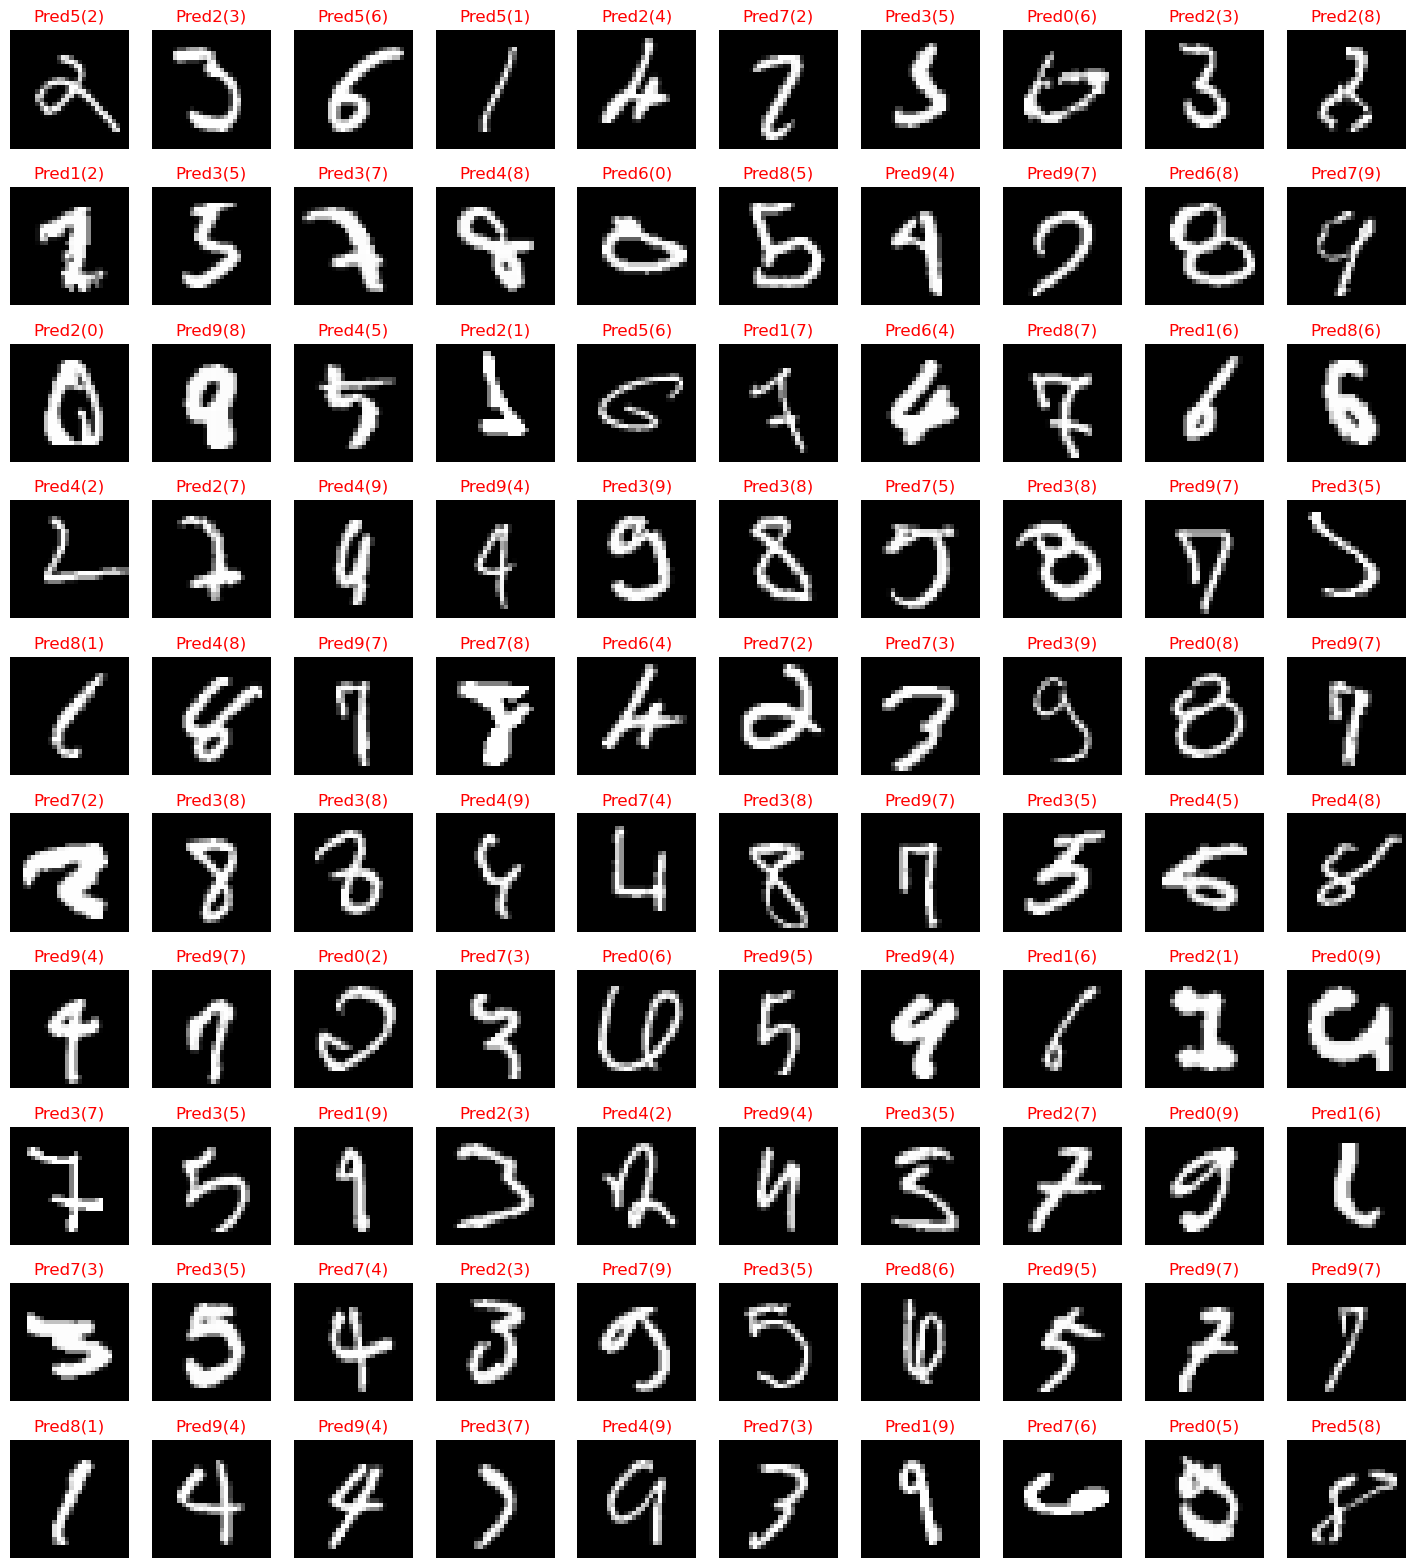

In [14]:
# 100 incorrect data
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure(figsize=(18 , 20))

for index in range(100):
    plt.subplot(10, 10, index + 1)
    plt.axis('off')
    plt.imshow(wrong_samples[index].numpy( ).reshape(28,28), cmap = "gray")
    plt.title("Pred" + str(wrong_preds[index].item()) + "(" + str(actual_preds[index].item()) + ")", color='red')

<div class="alert alert-block" style="border: 2px solid #1976D2;background-color:#E3F2FD;padding:5px;font-size:0.9em;">
본 자료는 저작권법 제25조 2항에 의해 보호를 받습니다. 본 자료를 외부에 공개하지 말아주세요.<br>
<b><a href="https://school.fun-coding.org/">잔재미코딩 (https://school.fun-coding.org/)</a> 에서 본 강의를 포함하는 최적화된 로드맵도 확인하실 수 있습니다</b></div>